In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# if you are interested in building a model and predicting
# who survived for a holdout sample, please take a look at:
# https://www.kaggle.com/c/titanic/overview

df = pd.read_csv('datasets/titanic.csv')
df = df.set_index('PassengerId')

In [3]:
dummies = pd.get_dummies(df['Sex'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
dummies = pd.get_dummies(df['Embarked'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)

In [4]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,Q,S
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0,1


In [5]:
# create train and test dataframes based on 80% train and 20% test

train, test = train_test_split(df, test_size = 0.2, stratify = df['Survived'], random_state = 42)

In [6]:
# separating out the independent and dependent variable labels

fn = ['Pclass', 'male', 'SibSp', 'Parch', 'Fare', 'Q', 'S']
cn = ['Survived']

In [7]:
# creating the independent and dependent variables for two
# models - logistic regression and classification

x_train = train[fn]
y_train = train[cn]
x_test = test[fn]
y_test = test[cn]

In [8]:
# logistic regression - we have seen this before

LogisticModel = sm.Logit(y_train, x_train).fit()
print(LogisticModel.summary())

Optimization terminated successfully.
         Current function value: 0.491333
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      705
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.2619
Time:                        22:43:39   Log-Likelihood:                -349.83
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 9.362e-51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass         0.0214      0.092      0.233      0.816      -0.158       0.201
male          -2.2078      0.

In [9]:
# we now use this model to help examine our testing set

y_hat = LogisticModel.predict(x_test)
compare = pd.concat([y_test, y_hat], axis=1)
compare = compare.rename(columns={0: 'y_hat'})
compare['difference'] = compare['Survived'] - compare['y_hat']
compare.sort_values(by=['difference'])

,Survived,y_hat,difference
PassengerId,,,
298,0,0.947245,-0.947245
28,0,0.921375,-0.921375
502,0,0.690108,-0.690108
503,0,0.689585,-0.689585
200,0,0.641556,-0.641556
...,...,...,...
490,1,0.129722,0.870278
456,1,0.120904,0.879096
554,1,0.119468,0.880532


In [10]:
prediction = list(map(round, y_hat)) 

# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[97 13]
 [23 46]]
Test accuracy =  0.7988826815642458


In [11]:
# this is the longer way to generate a confusion matrix
# go through the residuals to generate a confusion matrix

def rating(difference):
    if difference > 0.5:
        return "false negative"
    elif difference >= 0:
        return "true positive"
    elif difference >= -0.5:
        return "true negative"
    else:
        return "false positive"

compare['type'] = compare.apply(lambda x: rating(x['difference']),axis=1)
true_positives = compare[compare['type'] == "true positive"].count()["type"]
true_negatives = compare[compare['type'] == "true negative"].count()["type"]
false_positives = compare[compare['type'] == "false positive"].count()["type"]
false_negatives = compare[compare['type'] == "false negative"].count()["type"]
print("True positives: ", true_positives)
print("True negatives: ", true_negatives)
print("False positives: ", false_positives)
print("False negatives: ", false_negatives)


True positives:  46
True negatives:  97
False positives:  13
False negatives:  23


In [12]:
# we haven't seen this before, but we are going to measure
# the Receiver Operating Characteristic (ROC)
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

roc_auc_score(y_test, y_hat)

0.7946640316205534

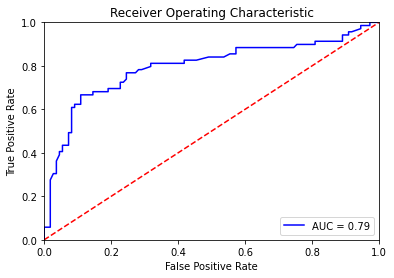

In [13]:
# we then take a look at the ROC curve

fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()